## GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#### 1. generate data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m
# print(Z)


# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    #throw one time, probability of getting 0 is 0.2, 1 = 0.2, 2 = 0.6
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k) 
#     print('z',z_vectors)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()
#labels = Z
# print(Z)
#one hot  = z_vectors

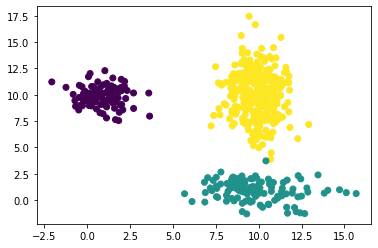

In [3]:
plt.scatter(X[:,0],X[:,1],c = Z)
plt.show()

### 2. Training

In [4]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        #pj is multivariate_normal.pdf in CP class
        pj = Gaussian(X, Mu[:,j], Sigma[j,:,:])
        pj_arr[0:m,j] = pj
        W[:,j] = Phi[j] * pj

    # W tells us what is the relative weight of each cluster for each data point
    #responsibilities
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    #take pj according to labels #probability of belonging to that particular label
    pj = pj_arr[np.arange(0,m,1),labels]
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label


### 2.1 Choosing k

In [20]:
K = 8

likelihoods = []
threshold = np.matrix(.01)

for k in range(2,K+1):
    print(k,end= "\t")
    likelihood = -float('inf')
    
    for attempt in range(10):
        Phi, Mu, Sigma = init_gmm(X, k)

        converged = False
        while not converged:
            converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

        l = np.mean(np.log(pj))
        if(l > likelihood):
            likelihood = l
        
    print(likelihood)
    likelihoods.append(likelihood)

2	-4.098109490141353
3	-3.37639809140284
4	-3.148650101870571
5	-2.9182325142131504
6	-2.8041471076450035
7	-2.6712406212964757
8	-2.55653867467733


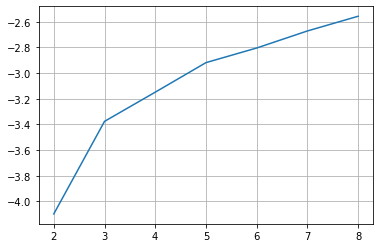

In [21]:
plt.plot(range(2,K+1),likelihoods)
plt.grid(True)

### 2.2 Training with selected k

In [22]:
threshold = np.matrix(.01)
k = 3
Phi, Mu, Sigma = init_gmm(X, k)
# print(Phi)
# print(Mu)
# print(Sigma)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [23]:
# X_label
#probability of belonging to that particular label
# print(pj.shape)
# print(pj)

In [24]:
print("======== Phi =========")
print(Phi)
print(phi_gt)
print("======== Mu =========")
print(Mu.T)
print(means_gt)
print("======== Sigma =========")
print(Sigma)
print(sigmas_gt)

======== Phi =========
[0.22230062 0.58969938 0.188     ]
[0.2, 0.2, 0.6]
======== Mu =========
[[ 9.86873511  0.88060638]
 [ 9.90823591 10.02460095]
 [ 0.91998177  9.83821449]]
[[1, 10], [10, 1], [10, 10]]
======== Sigma =========
[[[ 3.69438311 -0.29480155]
  [-0.29480155  0.86085994]]

 [[ 0.89245893 -0.1756117 ]
  [-0.1756117   4.77491924]]

 [[ 0.98466605 -0.08557729]
  [-0.08557729  0.91538471]]]
[matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### 3. Outlier: Threshold

In [8]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]
print(outliers)

[  7  10  20  28  36  63  73  83  84  88  90  98 105 115 119 131 132 138
 144 192 198 199 218 219 220 223 225 228 232 242 262 266 293 305 320 333
 356 359 362 363 364 365 367 369 387 393 405 407 417 426 439 441 463 482
 499]


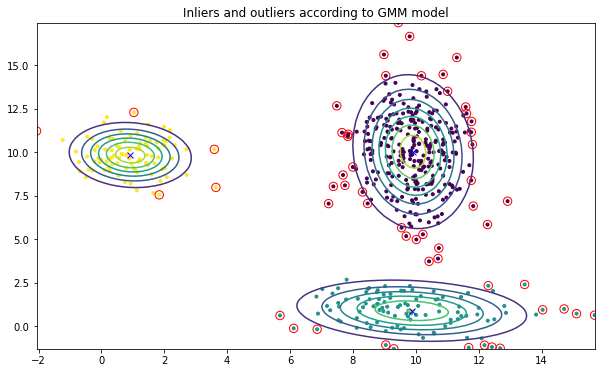

In [9]:
plt.figure(figsize=(10,6))
#c = pj: colors according to the probability of that particular point belong to that cluster
# c = X_label[:,2] or Z: colors according to cluster it belongs to
plt.scatter(X[:,0],X[:,1],marker=".",c=X_label[:,2],cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(min(X_class[:,0]), max(X_class[:,0]), 30)
    ylist = np.linspace(min(X_class[:,1]), max(X_class[:,1]), 30)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)
plt.title('Inliers and outliers according to GMM model')
plt.show()

### 3. Outlier: Mahalanobis Distance

In [16]:
best_Phi = Phi
best_Mu = Mu
best_Sigma = Sigma

m_distance = np.zeros((X.shape[0],best_Mu.shape[1]))

        
for kk in range(best_Mu.shape[1]):
    for i, x in enumerate(X):
        mu = best_Mu[:,kk]
        sig = best_Sigma[kk]
        sig_inv = np.linalg.inv(sig)
        diff = (mu-x).reshape(-1,1)
        distance = np.sqrt(diff.T@sig_inv@diff)
        m_distance[i,kk] = distance

print(m_distance)
a = np.argmin(m_distance,axis=1)
(unique, counts) = np.unique(a, return_counts=True)
# print(unique,counts)
max_z_score = 2
min_distance = np.min(m_distance,axis=1)
# print(min_distance)
outlier_maha = min_distance > max_z_score
outlier_maha = np.nonzero(outlier_maha)[0]
print(outlier_maha)

[[ 0.7861664  10.76879294  8.54278574]
 [ 1.45707254 10.78106387 10.5418533 ]
 [ 9.44625649  9.29296112  0.89410693]
 ...
 [ 4.15039021  0.84157402 11.27250566]
 [ 4.76483188  1.00285729 12.27164516]
 [ 3.04047569 17.23062405 11.98499066]]
[  7  10  19  20  28  36  63  73  83  84  87  88  90  98 105 115 119 130
 131 132 138 144 192 197 198 199 211 218 219 220 223 225 228 232 242 246
 262 266 293 299 305 320 333 352 356 359 362 363 364 365 367 369 387 393
 405 407 417 426 439 441 445 449 456 463 464 465 469 475 482 499]


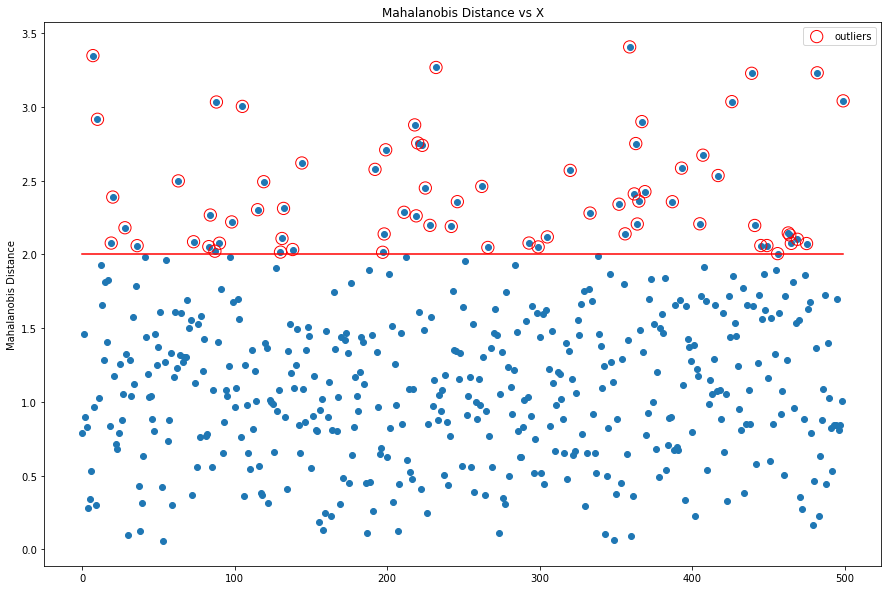

In [17]:
fig = plt.figure(figsize=(15,10))

plt.title("Mahalanobis Distance vs X")
plt.plot(range(X.shape[0]),np.full(X.shape[0],max_z_score),c='r')
plt.ylabel("Mahalanobis Distance")

plt.scatter(range(X.shape[0]),min_distance)
plt.scatter(outlier_maha,min_distance[outlier_maha],s=150,facecolor='none',edgecolor = 'r',label="outliers")
plt.legend()

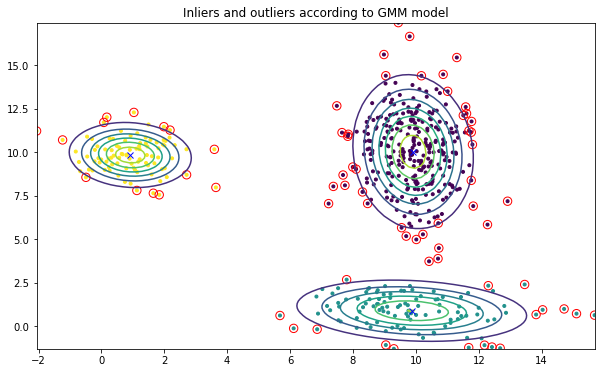

In [18]:
plt.figure(figsize=(10,6))
#c = pj: colors according to the probability of that particular point belong to that cluster
# c = X_label[:,2] or Z: colors according to cluster it belongs to
plt.scatter(X[:,0],X[:,1],marker=".",c=X_label[:,2],cmap='viridis');
plt.scatter(X[outlier_maha,0],X[outlier_maha,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(min(X_class[:,0]), max(X_class[:,0]), 30)
    ylist = np.linspace(min(X_class[:,1]), max(X_class[:,1]), 30)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)
plt.title('Inliers and outliers according to GMM model')
plt.show()